# Language Creation Model

## Dataset Preperation

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
filepath = "eng_sentences.tsv"
with open(filepath, encoding="utf-8") as f:
    english_sentences = f.readlines()

In [3]:
load_samples = 200000  # number of sentences loaded during preprocessing
tokenizer_samples = 10000  # number of sentences to fit the tokenizer on
num_sentences = 40000  # number of sentences used during training
max_sentence_len = 12  # words

english_sentences = [sentence[sentence.index("\t")+5:-1] for sentence in english_sentences if len(sentence[sentence.index("\t")+5:-1].split()) <= max_sentence_len][:load_samples]
np.random.seed(42)
np.random.shuffle(english_sentences)

In [4]:
max_id = 1500  # vocabulary size
tokenizer = keras.preprocessing.text.Tokenizer(num_words=max_id, oov_token='OOV')
tokenizer.fit_on_texts(english_sentences[:tokenizer_samples])

In [5]:
tokenizer.texts_to_sequences(["First"])

[[168]]

In [6]:
tokenizer.sequences_to_texts([[168]])

['first']

In [7]:
tokenized = tokenizer.texts_to_sequences(english_sentences)
indexes = [1 not in x and len(x) <= max_sentence_len for x in tokenized]  # No sentences with oov-words
tokenized = np.array(tokenized, dtype=object)[indexes][:num_sentences]
english_sentences = np.array(english_sentences, dtype=object)[indexes][:num_sentences]

encoded = tf.keras.preprocessing.sequence.pad_sequences([x for x in tokenized if not 1 in x], padding="post")

In [8]:
batch_size = 32

X_train, X_val, _, _ = train_test_split(encoded, encoded, test_size=0.1, random_state=42)
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
X_train_dataset = X_train_dataset.batch(batch_size)
ae_training_dataset = X_train_dataset.map(lambda X_batch: (X_batch, tf.one_hot(X_batch, depth=max_id)))

X_val_dataset = tf.data.Dataset.from_tensor_slices(X_val)
X_val_dataset = X_val_dataset.batch(batch_size)
ae_validation_dataset = X_val_dataset.map(lambda X_batch: (X_batch, tf.one_hot(X_batch, depth=max_id)))

## Creating the models

In [9]:
encoder_decoder_model_file = r"Trained Model1 (1xGRU)/encoder_decoder_model.hdf5"
eng2lang_model_file = r"Trained Model1 (1xGRU)/eng2lang_model.hdf5"
lang2eng_model_file = r"Trained Model1 (1xGRU)/lang2eng_model.hdf5"

### Encoder / Decoder Model

In [10]:
def generate_encoder_decoder_model(regularization=False, load_weights=None):
    reg = None
    if regularization:
        reg = keras.regularizers.l1_l2(1e-3)
    
    model_inputs = keras.Input(shape=(max_sentence_len), name="inputs")
    model_embedding = keras.layers.Embedding(max_id, 16, name="embed")(model_inputs)

    model_gru = keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True, kernel_regularizer=reg), name="gru")(model_embedding)
    model_outputs = keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax", 
                                                                     kernel_regularizer=reg, name="outputs"))(model_gru)
    
    model = keras.Model(inputs=model_inputs, outputs=model_outputs)
    
    if load_weights:
        model.load_weights(load_weights)
    
    return model

In [11]:
encoder_decoder_model = generate_encoder_decoder_model(regularization=False)
encoder_decoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 12)]              0         
_________________________________________________________________
embed (Embedding)            (None, 12, 16)            24000     
_________________________________________________________________
gru (Bidirectional)          (None, 12, 512)           420864    
_________________________________________________________________
time_distributed (TimeDistri (None, 12, 1500)          769500    
Total params: 1,214,364
Trainable params: 1,214,364
Non-trainable params: 0
_________________________________________________________________


In [12]:
encoder_decoder_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

encoder_decoder_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=encoder_decoder_model_file,
    monitor='accuracy',
    mode='max',
    save_freq="epoch",
    save_best_only=True,
    save_weights_only=True)

history = encoder_decoder_model.fit(ae_training_dataset, epochs=3, callbacks=[encoder_decoder_model_checkpoint_callback], 
                                    validation_data=ae_validation_dataset)

Epoch 1/3
1125/1125 [==============================] - 52s 44ms/step - loss: 1.8952 - accuracy: 0.7034 - val_loss: 0.2877 - val_accuracy: 0.9573
Epoch 2/3
1125/1125 [==============================] - 48s 43ms/step - loss: 0.0881 - accuracy: 0.9887 - val_loss: 0.0210 - val_accuracy: 0.9980
Epoch 3/3
1125/1125 [==============================] - 48s 43ms/step - loss: 0.0074 - accuracy: 0.9996 - val_loss: 0.0060 - val_accuracy: 0.9994


### Eng2Lang Model

#### Training with regularization

In [13]:
eng2lang_model = generate_encoder_decoder_model(regularization=True, load_weights=encoder_decoder_model_file)
eng2lang_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

eng2lang_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=eng2lang_model_file,
    monitor='accuracy',
    mode='max',
    save_freq="epoch",
    save_best_only=True,
    save_weights_only=True)
history = eng2lang_model.fit(ae_training_dataset, epochs=3, callbacks=[eng2lang_model_checkpoint_callback], 
                             validation_data=ae_validation_dataset)

Epoch 1/3
1125/1125 [==============================] - 56s 48ms/step - loss: 40.7996 - accuracy: 0.7673 - val_loss: 7.7005 - val_accuracy: 0.6826
Epoch 2/3
1125/1125 [==============================] - 56s 50ms/step - loss: 4.5282 - accuracy: 0.6736 - val_loss: 3.3356 - val_accuracy: 0.6597
Epoch 3/3
1125/1125 [==============================] - 53s 47ms/step - loss: 3.1708 - accuracy: 0.6688 - val_loss: 3.0865 - val_accuracy: 0.6715


#### Rehabilitation phase

In [14]:
eng2lang_model = generate_encoder_decoder_model(regularization=False, load_weights=eng2lang_model_file)
eng2lang_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

eng2lang_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=eng2lang_model_file,
    monitor='accuracy',
    mode='max',
    save_freq="epoch",
    save_best_only=True,
    save_weights_only=True)
history = eng2lang_model.fit(ae_training_dataset.take(15), epochs=1, callbacks=[eng2lang_model_checkpoint_callback], 
                             validation_data=ae_validation_dataset)

15/15 [==============================] - 5s 190ms/step - loss: 2.1505 - accuracy: 0.7010 - val_loss: 2.0526 - val_accuracy: 0.7097


### Lang2Eng Model

In [15]:
ae_training_dataset2 = X_train_dataset.map(lambda X_batch: (tf.argmax(eng2lang_model(X_batch), axis=-1), tf.one_hot(X_batch, depth=max_id)))
ae_validation_dataset2 = X_val_dataset.map(lambda X_batch: (tf.argmax(eng2lang_model(X_batch), axis=-1), tf.one_hot(X_batch, depth=max_id)))

In [16]:
lang2eng_model = generate_encoder_decoder_model(regularization=False, load_weights=encoder_decoder_model_file)

lang2eng_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

lang2eng_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=lang2eng_model_file,
    monitor='accuracy',
    mode='max',
    save_freq="epoch",
    save_best_only=True,
    save_weights_only=True)
history = lang2eng_model.fit(ae_training_dataset2, epochs=25, callbacks=[lang2eng_model_checkpoint_callback], 
                             validation_data=ae_validation_dataset2)

Epoch 1/25
1125/1125 [==============================] - 75s 65ms/step - loss: 1.3089 - accuracy: 0.7462 - val_loss: 1.1292 - val_accuracy: 0.7621
Epoch 2/25
1125/1125 [==============================] - 75s 67ms/step - loss: 1.0269 - accuracy: 0.7748 - val_loss: 1.0484 - val_accuracy: 0.7758
Epoch 3/25
1125/1125 [==============================] - 74s 65ms/step - loss: 0.9119 - accuracy: 0.7926 - val_loss: 1.0149 - val_accuracy: 0.7815
Epoch 4/25
1125/1125 [==============================] - 73s 65ms/step - loss: 0.8192 - accuracy: 0.8085 - val_loss: 1.0028 - val_accuracy: 0.7841
Epoch 5/25
1125/1125 [==============================] - 76s 68ms/step - loss: 0.7374 - accuracy: 0.8235 - val_loss: 1.0022 - val_accuracy: 0.7852
Epoch 6/25
1125/1125 [==============================] - 75s 67ms/step - loss: 0.6627 - accuracy: 0.8382 - val_loss: 1.0096 - val_accuracy: 0.7867
Epoch 7/25
1125/1125 [==============================] - 73s 65ms/step - loss: 0.5940 - accuracy: 0.8531 - val_loss: 1.0242 -

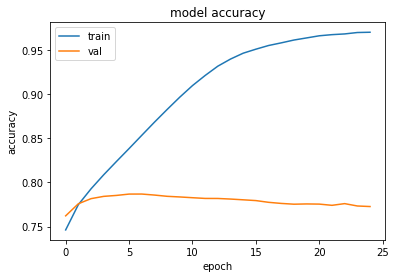

In [17]:
# Example of plotting accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing

### Load models (optional)

In [11]:
# This only needs to be run if you haven't already run the "Creating the models" section of this notebooks
# (First run data prep. and generation-function, then this cell)

# eng2lang_model = generate_encoder_decoder_model(regularization=False, load_weights=eng2lang_model_file)
# lang2eng_model = generate_encoder_decoder_model(regularization=False, load_weights=lang2eng_model_file)

### Test models

In [19]:
def preprocess(texts):
    tokenized = tokenizer.texts_to_sequences(texts)
    X = np.array(keras.preprocessing.sequence.pad_sequences(tokenized, padding="post", maxlen=max_sentence_len))
    
    return X

In [20]:
def eng2lang_predict(sentence):
    X_new = preprocess([sentence])
    prediction = np.argmax(eng2lang_model.predict(X_new), axis=-1)
    return tokenizer.sequences_to_texts([prediction[prediction != 0]])[0]

In [21]:
def lang2eng_predict(sentence):
    X_new = preprocess([sentence])
    prediction = np.argmax(lang2eng_model.predict(X_new), axis=-1)
    return tokenizer.sequences_to_texts([prediction[prediction != 0]])[0]

In [22]:
def eng2eng_predict(sentence):
    return lang2eng_predict(eng2lang_predict(sentence))

In [23]:
# Example sentences from the dataset
for i in range(10):
    print(np.random.choice(english_sentences))

I thought that book was difficult to read.
Keep your hands off my daughter!
I would go at 10.
I'm all ears.
This winter is warm.
Beautiful day, isn't it?
It is necessary for you to start at once.
I'll give you five dollars.
When I call on you, I'll let you know in advance.
She looked very beautiful in her new dress.


In [24]:
for i in range(10):
    sentence = np.random.choice(english_sentences)
    print("Original sentence: \n", sentence)
    print("1) Translated to language: \n", eng2lang_predict(sentence))
    print("2) Translated from language: \n", lang2eng_predict(sentence))
    print("3) Translated to language and back: \n", eng2eng_predict(sentence))
    print()

Original sentence: 
 I can't do such a thing like you did.
1) Translated to language: 
 i like do in a out like you did
2) Translated from language: 
 i wouldn't better such a thing about you did
3) Translated to language and back: 
 i can't do such a position yen you did

Original sentence: 
 The society made him president.
1) Translated to language: 
 the didn't know him there
2) Translated from language: 
 the dress made help immediately
3) Translated to language and back: 
 the society made him president

Original sentence: 
 You don't get up as early as your sister.
1) Translated to language: 
 you don't get up as in as your what
2) Translated from language: 
 you don't get up as early as your sister
3) Translated to language and back: 
 you don't get up as talk as your sister

Original sentence: 
 You have a way with women.
1) Translated to language: 
 you have a and with and
2) Translated from language: 
 you have a way with women
3) Translated to language and back: 
 you have a

In [25]:
# Translate custom sentence
sentence = "He will not be able to do the work."

print("1) Translated to language: \n", eng2lang_predict(sentence))
print("2) Translated from language: \n", lang2eng_predict(sentence))
print("3) Translated to language and back: \n", eng2eng_predict(sentence))

1) Translated to language: 
 he will not be out to do the go
2) Translated from language: 
 he will not be able to do the work
3) Translated to language and back: 
 he will not be able to do the work
